# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [3]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor


## ⚙️ Step 2: Environment Setup

In [4]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "CartPole-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

trajectory_seed = 42
seed = 2025                  # Random seed to ensure experiment reproducibility
seed = 2024                  # Random seed to ensure experiment reproducibility
seed = 42

total_timesteps = 40_000   # Number of training steps for Expert PPO (Recommended: 30k for CartPole, 300k for Pendulum)

num_prefs    = 1000            # Number of preference samples
sample_prefs = 200

# ===========================================================

set_random_seed(seed)

env = gym.make(env_id)

is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 200
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'} | sample_length: {sample_length}")


✅ Environment: CartPole-v1 | Action space: Discrete | sample_length: 200


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [5]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=trajectory_seed, device="cpu")
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{trajectory_seed}.zip")
env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 21.2     |
| time/              |          |
|    fps             | 2038     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.6        |
|    ep_rew_mean          | 25.6        |
| time/                   |             |
|    fps                  | 1245        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009402724 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss   

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [6]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env, device="cpu"), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))

pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env, device="cpu")
pi2_model.save(f"{env_id}_pi2_model_seed{trajectory_seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_16000_steps.zip with ~227.0 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [7]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset()

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.stack(rewards),       # [T]
        "mask": np.stack(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(model = pi2_model,    env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")




🔄 Generating preference pairs: 100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


✅ Saved 1000 preference pairs to prefs_CartPole-v1_seed42.pkl


In [8]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## ⚙️ Step 7: Train DPO Policy

---

In [9]:
# Only for plot
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


In [10]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=0, epochs=50, device='cuda'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    
    model = PPO("MlpPolicy", env, verbose=0, seed=seed, device="cuda")
    policy = model.policy
    policy.train()  # ensure in training mode
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]

            obs1_flat = obs1.view(-1, obs_dim)
            obs2_flat = obs2.view(-1, obs_dim)
            acts1_flat = acts1.view(-1) if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1) if is_discrete else acts2.view(-1, act_dim)

            dist1 = policy.get_distribution(obs1_flat)  # returns Categorical
            dist2 = policy.get_distribution(obs2_flat)
            lp1 = dist1.log_prob(acts1_flat).view(B, T)  # [B, T]
            lp2 = dist2.log_prob(acts2_flat).view(B, T)
            
            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = logp1_sum - logp2_sum        # [B]

            loss = F.binary_cross_entropy_with_logits(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

#with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
#    prefs = pickle.load(f)
#prefs = prefs[:sample_prefs]

#dataset = PreferenceDataset(prefs, is_discrete)
#loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

#dpo_model = train_dpo(loader, env)
#torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

In [11]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO
import copy

def train_dpo_from_ref(dataloader,ref_policy_sb3, env, beta= 0.05,  seed=42, epochs=50, device='cuda'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]


    ref_policy = ref_policy_sb3.policy  # frozen
    policy = copy.deepcopy(ref_policy)  # trainable

    policy.to(device)
    ref_policy.to(device)
    ref_policy.eval()  # ensure frozen

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log probs from trainable policy ---

            dist1 = policy.get_distribution(obs1_flat)
            dist2 = policy.get_distribution(obs2_flat)

            logp1 = dist1.log_prob(acts1_flat)
            logp2 = dist2.log_prob(acts2_flat)



            #logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            #logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)

            # --- Compute log probs from reference policy (frozen) ---
            with torch.no_grad():
                dist1_ref = ref_policy.get_distribution(obs1_flat)
                dist2_ref = ref_policy.get_distribution(obs2_flat)

                logp1_ref = dist1_ref.log_prob(acts1_flat)
                logp2_ref = dist2_ref.log_prob(acts2_flat)

                #logp1_ref = torch.log_softmax(ref_policy(obs1_flat), dim=-1)
                #logp2_ref = torch.log_softmax(ref_policy(obs2_flat), dim=-1)


            lp1 = (logp1 - logp1_ref).view(B, -1)  # shape [B, T]
            lp2 = (logp2 - logp2_ref).view(B, -1)


            #lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            #lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits =beta*(logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

In [12]:
with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]
dataset = PreferenceDataset(prefs, is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
dpo_model_from_ref = train_dpo_from_ref(loader,pi2_model, env, beta=0.5, seed=seed)
torch.save(dpo_model_from_ref.state_dict(), f"{env_id}_dpo_pi2_seed{seed}.pth")

dpo_model = train_dpo(loader, env, seed=seed)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Epoch 1/50, Loss: 0.6507
Epoch 2/50, Loss: 0.5977
Epoch 3/50, Loss: 0.5875
Epoch 4/50, Loss: 0.5730
Epoch 5/50, Loss: 0.5842
Epoch 6/50, Loss: 0.6056
Epoch 7/50, Loss: 0.6038
Epoch 8/50, Loss: 0.6136
Epoch 9/50, Loss: 0.5658
Epoch 10/50, Loss: 0.6249
Epoch 11/50, Loss: 0.5677
Epoch 12/50, Loss: 0.5680
Epoch 13/50, Loss: 0.6237
Epoch 14/50, Loss: 0.6106
Epoch 15/50, Loss: 0.5732
Epoch 16/50, Loss: 0.5730
Epoch 17/50, Loss: 0.5713
Epoch 18/50, Loss: 0.5968
Epoch 19/50, Loss: 0.5574
Epoch 20/50, Loss: 0.5673
Epoch 21/50, Loss: 0.5912
Epoch 22/50, Loss: 0.5736
Epoch 23/50, Loss: 0.5774
Epoch 24/50, Loss: 0.5636
Epoch 25/50, Loss: 0.5593
Epoch 26/50, Loss: 0.5525
Epoch 27/50, Loss: 0.5697
Epoch 28/50, Loss: 0.5659
Epoch 29/50, Loss: 0.5654
Epoch 30/50, Loss: 0.5581
Epoch 31/50, Loss: 0.5536
Epoch 32/50, Loss: 0.5647
Epoch 33/50, Loss: 0.5839
Epoch 34/50, Loss: 0.5529
Epoch 35/50, Loss: 0.5618
Epoch 36/50, Loss: 0.5810
Epoch 37/50, Loss: 0.5384
Epoch 38/50, Loss: 0.5617
Epoch 39/50, Loss: 0.

c:\Users\MATH-286-Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Epoch 1/50, Loss: 11.1941
Epoch 2/50, Loss: 10.5926
Epoch 3/50, Loss: 10.7247
Epoch 4/50, Loss: 10.3673
Epoch 5/50, Loss: 10.2439
Epoch 6/50, Loss: 10.6434
Epoch 7/50, Loss: 10.7026
Epoch 8/50, Loss: 10.5175
Epoch 9/50, Loss: 10.4661
Epoch 10/50, Loss: 10.4603
Epoch 11/50, Loss: 10.1367
Epoch 12/50, Loss: 10.3791
Epoch 13/50, Loss: 9.8425
Epoch 14/50, Loss: 9.6962
Epoch 15/50, Loss: 9.6947
Epoch 16/50, Loss: 9.8538
Epoch 17/50, Loss: 9.3615
Epoch 18/50, Loss: 9.7415
Epoch 19/50, Loss: 9.8679
Epoch 20/50, Loss: 9.1417
Epoch 21/50, Loss: 9.7484
Epoch 22/50, Loss: 9.2697
Epoch 23/50, Loss: 9.2505
Epoch 24/50, Loss: 9.3382
Epoch 25/50, Loss: 9.4050
Epoch 26/50, Loss: 9.0450
Epoch 27/50, Loss: 9.0781
Epoch 28/50, Loss: 9.0714
Epoch 29/50, Loss: 9.3245
Epoch 30/50, Loss: 9.2698
Epoch 31/50, Loss: 9.1110
Epoch 32/50, Loss: 9.5524
Epoch 33/50, Loss: 9.2199
Epoch 34/50, Loss: 9.1432
Epoch 35/50, Loss: 9.0144
Epoch 36/50, Loss: 9.1365
Epoch 37/50, Loss: 9.4307
Epoch 38/50, Loss: 8.9900
Epoch 39/

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [13]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(dataloader, obs_dim, act_dim, is_discrete, epochs=200, lr=1e-3, seed = None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)
        
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            r1 = model(obs1.view(-1, obs_dim), acts1.view(-1) if is_discrete else acts1.view(-1, act_dim))
            r2 = model(obs2.view(-1, obs_dim), acts2.view(-1) if is_discrete else acts2.view(-1, act_dim))

            r1 = r1.view(obs1.shape[0], obs1.shape[1]) * mask1
            r2 = r2.view(obs2.shape[0], obs2.shape[1]) * mask2

            r1_sum = r1.sum(dim=1)  # [B]
            r2_sum = r2.sum(dim=1)  # [B]

            logits = r1_sum - r2_sum  # [B]
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

with open(f"prefs_{env_id}_seed{trajectory_seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]

dataset = PreferenceDataset(prefs, is_discrete=is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

reward_model = train_reward_model(loader, obs_dim, act_dim, is_discrete)
torch.save(reward_model.state_dict(), f"{env_id}_reward_model_seed{seed}.pth")


Epoch 1/200, Loss: 6.3387
Epoch 2/200, Loss: 1.5809
Epoch 3/200, Loss: 1.1296
Epoch 4/200, Loss: 0.6560
Epoch 5/200, Loss: 0.5483
Epoch 6/200, Loss: 0.5006
Epoch 7/200, Loss: 0.4628
Epoch 8/200, Loss: 0.4474
Epoch 9/200, Loss: 0.4407
Epoch 10/200, Loss: 0.4243
Epoch 11/200, Loss: 0.4251
Epoch 12/200, Loss: 0.4303
Epoch 13/200, Loss: 0.4236
Epoch 14/200, Loss: 0.4270
Epoch 15/200, Loss: 0.4115
Epoch 16/200, Loss: 0.4086
Epoch 17/200, Loss: 0.4152
Epoch 18/200, Loss: 0.4069
Epoch 19/200, Loss: 0.4007
Epoch 20/200, Loss: 0.4165
Epoch 21/200, Loss: 0.3998
Epoch 22/200, Loss: 0.4018
Epoch 23/200, Loss: 0.3976
Epoch 24/200, Loss: 0.4018
Epoch 25/200, Loss: 0.3935
Epoch 26/200, Loss: 0.4126
Epoch 27/200, Loss: 0.3938
Epoch 28/200, Loss: 0.3844
Epoch 29/200, Loss: 0.4088
Epoch 30/200, Loss: 0.3908
Epoch 31/200, Loss: 0.3945
Epoch 32/200, Loss: 0.3923
Epoch 33/200, Loss: 0.3875
Epoch 34/200, Loss: 0.3774
Epoch 35/200, Loss: 0.3934
Epoch 36/200, Loss: 0.3788
Epoch 37/200, Loss: 0.3848
Epoch 38/2

## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [14]:
# import gymnasium as gym
# from gymnasium import Wrapper

# class RewardNetWrapper(Wrapper):
#     def __init__(self, env, reward_net, is_discrete):
#         super().__init__(env)
#         self.reward_net = reward_net
#         self.is_discrete = is_discrete

#     def step(self, action):
#         obs, reward, terminated, truncated, info = self.env.step(action)

#         # Convert to tensor
#         obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
#         if self.is_discrete:
#             act_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)
#         else:
#             act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

#         # Predict learned reward
#         with torch.no_grad():
#             reward = self.reward_net(obs_tensor, act_tensor).item()

#         return obs, reward, terminated, truncated, info

# # Wrap the environment with the trained reward_net
# reward_model.eval()  # Ensure the model is in inference mode
# env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
# env = Monitor(env)

# # Retrain the policy using the new reward
# rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
# rlhf_model.learn(total_timesteps=total_timesteps)
# rlhf_model.save(f"{env_id}_rlhf_seed{seed}.zip")

import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor and move to reward_net's device
        device = next(self.reward_net.parameters()).device
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32, device=device).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# Wrap the environment with the trained reward_net
reward_model.eval()  # Ensure the model is in inference mode
env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
env = Monitor(env)

# Retrain the policy using the new reward
path_model_pi_2 = f"{env_id}_pi2_model_seed{seed}.zip"
print(path_model_pi_2)

# rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed, device="cpu")
rlhf_model = PPO.load(path   = path_model_pi_2, 
                      env    = env, 
                      seed   = seed, 
                      device = "cpu",
                      kl_coeff = 0.5,
                      target_kl= 0.01)  # KL penalty coefficient 0.01

# rlhf_model.learn(total_timesteps=total_timesteps)
# rlhf_model.learn(total_timesteps=total_timesteps // 2) #FF0000
# rlhf_model.learn(total_timesteps=60000) #FF0000
rlhf_model.learn(total_timesteps=20000) #FF0000
rlhf_model.save(f"{env_id}_rlhf_pi2_seed{seed}.zip")

CartPole-v1_pi2_model_seed42.zip
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 202      |
|    ep_rew_mean     | 104      |
| time/              |          |
|    fps             | 822      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 257          |
|    ep_rew_mean          | 133          |
| time/                   |              |
|    fps                  | 593          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0056882165 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO vs PI2 vs DPO from PI2

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2158475483.py:27: SyntaxWarning: invalid escape sequence '\p'
  labels=["Expert ($\pi_1$)",
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2158475483.py:28: SyntaxWarning: invalid escape sequence '\p'
  "$\pi_2$ RLHF",
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2158475483.py:29: SyntaxWarning: invalid escape sequence '\p'
  "$\pi_2$",
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2158475483.py:30: SyntaxWarning: invalid escape sequence '\p'
  "$\pi_2$ DPO"],


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2158475483.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pi2_dpo.load_state_dict(torch.load(f"{env_id}

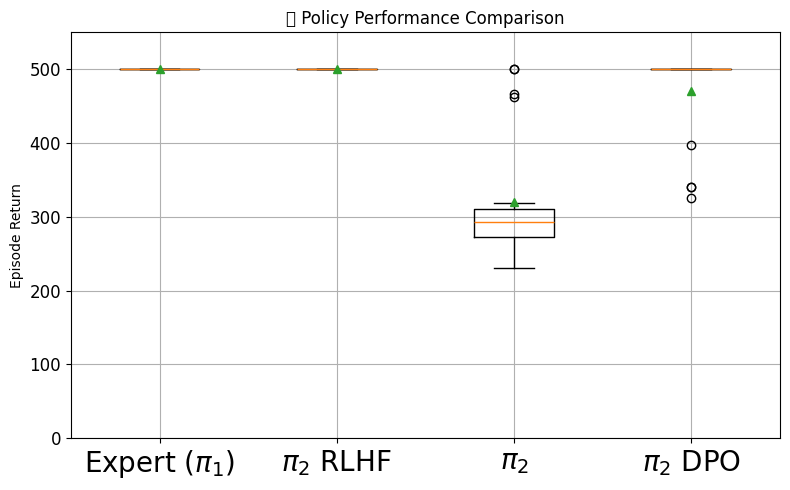

In [15]:
def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns

import copy
env = gym.make(env_id)
returns_pi1 = eval_policy(PPO.load(f"{env_id}_expert_seed{trajectory_seed}.zip", env=env), env)
returns_pi2 = eval_policy(PPO.load(f"{env_id}_pi2_model_seed{trajectory_seed}.zip", env=env), env)
returns_pi2_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_pi2_seed{seed}.zip", env=env), env)
model_pi2_dpo = copy.deepcopy(pi2_model.policy)
model_pi2_dpo.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))
returns_pi2_dpo = eval_policy(model_pi2_dpo, env)


plt.figure(figsize=(8, 5))
plt.boxplot([returns_pi1, returns_pi2_rlhf, returns_pi2, returns_pi2_dpo],
            labels=["Expert ($\pi_1$)", 
                    "$\pi_2$ RLHF", 
                    "$\pi_2$", 
                    "$\pi_2$ DPO"],
            showmeans=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.ylim(0, 550)
plt.title("🎯 Policy Performance Comparison")
plt.ylabel("Episode Return")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{env_id}_benchmark_{seed}_dataset{sample_prefs}.png", dpi=300)
plt.show()

<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2285934552.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "$\pi_2$ RLHF",  "$\pi_2$", "$\pi_2$ DPO"]
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2285934552.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "$\pi_2$ RLHF",  "$\pi_2$", "$\pi_2$ DPO"]
C:\Users\MATH-286-Dell\AppData\Local\Temp\ipykernel_18076\2285934552.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "$\pi_2$ RLHF",  "$\pi_2$", "$\pi_2$ DPO"]
c:\Users\MATH-286-Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserW

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


✅ GIF saved to: d:\EPFL\Course\MA2\[EE-568] Reinforcement Learning\EE-568-RL\CartPole-v1_comparison_seed42_dataset200.gif


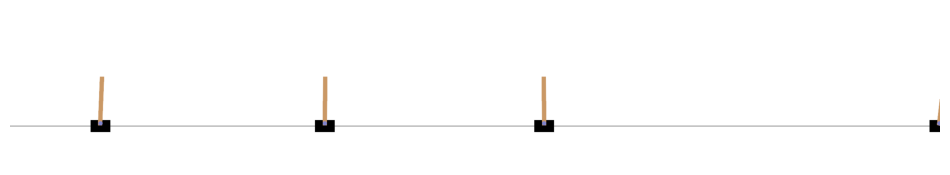

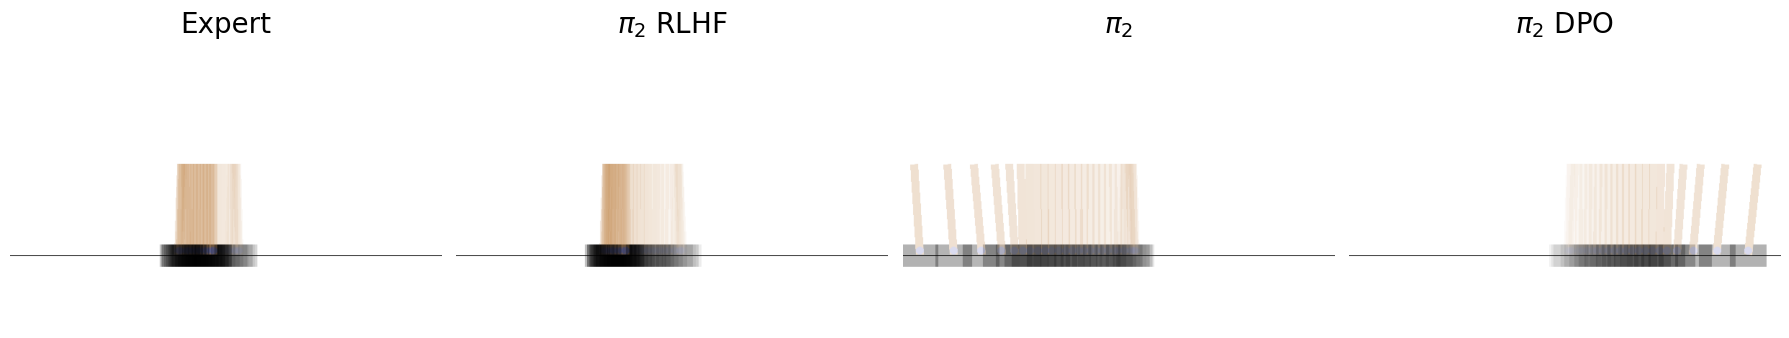

In [18]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: Run a single episode and record rendered frames
def record_episode(model, env, is_sb3=True, seed=None, max_steps=1000):
    frames = []
    obs, _ = env.reset(seed=seed)
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: Combine multiple frame sequences into a single animation and optionally save as a GIF
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

def trajectory_overlay_faded(frames, threshold=30, min_alpha=0.05, max_alpha=0.3):
    frames = [f.astype(np.float32) for f in frames]
    H, W, C = frames[0].shape

    overlay = np.ones((H, W, C), dtype=np.float32) * 255
    num_frames = len(frames)

    for idx, frame in enumerate(frames):
        diff = np.abs(frame - 255)
        mask = (diff.mean(axis=2) > threshold)

        alpha = min_alpha + (max_alpha - min_alpha) * (idx / (num_frames - 1))

        for c in range(3):
            overlay[:, :, c][mask] = (
                alpha * frame[:, :, c][mask] +
                (1 - alpha) * overlay[:, :, c][mask]
            )
    return np.clip(overlay, 0, 255).astype(np.uint8)

def show_trajectory_comparison(img_expert, img_rlhf, img_pi2, img_dpo_from_pi2, titles=None):
    if titles is None:
        titles = ["Expert", "$\pi_2$ RLHF",  "$\pi_2$", "$\pi_2$ DPO"]

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    images = [img_expert, img_rlhf, img_pi2, img_dpo_from_pi2]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{env_id}_render_{seed}_dataset{sample_prefs}.png", dpi=300)
    plt.show()
    
# Step 3: Load models and environments
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_pi2 = gym.make(env_id, render_mode="rgb_array")
env_dpo_from_pi2 = gym.make(env_id, render_mode="rgb_array")
expert_model = PPO.load(f"{env_id}_expert_seed{trajectory_seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_pi2_seed{seed}.zip", env=env_rlhf)
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{trajectory_seed}.zip", env=env_pi2)
model_pi2_dpo = copy.deepcopy(pi2_model.policy)
model_pi2_dpo.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))


# Step 4: Collect animation frames for all three strategies
frames_expert = record_episode(expert_model, env_expert, seed=seed)
frames_rlhf   = record_episode(rlhf_model, env_rlhf, seed=seed)
frames_pi2 = record_episode(pi2_model, env_pi2, seed=seed)
frames_dpo_from_pi2 = record_episode(model_pi2_dpo, env_dpo_from_pi2, seed=seed)

# Step 5: Display the combined animation and save it as a GIF file
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO vs PI2 vs DPO_PI2</h3>"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_pi2, frames_dpo_from_pi2],
    gif_path=f"{env_id}_comparison_seed{seed}_dataset{sample_prefs}.gif"
))

img_expert = trajectory_overlay_faded(frames_expert[::15], threshold=55)
img_rlhf = trajectory_overlay_faded(frames_rlhf[::15], threshold=55)
img_pi2 = trajectory_overlay_faded(frames_pi2[::15], threshold=55)
img_dpo_from_pi2 = trajectory_overlay_faded(frames_dpo_from_pi2[::15], threshold=55)
show_trajectory_comparison(img_expert, img_rlhf,  img_pi2, img_dpo_from_pi2)
